
Recognizing Traffic Signs

The goal of this project is to build a model capable of determining the type of traffic sign that is displayed in an image captured under different real-life conditions and showing obstructions, poor lighting, or even the sign being far away from the camera. We provide you with labeled images already splited in three files (tran/val/test) and a predefined list of signs to recognise.

In [22]:
import pandas as pd
import numpy as np
import zipfile
import pickle
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [2]:
# Download and unzip
dataroot = "dataroot/"
#!mkdir dataroot 
#!curl https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip -L -o dataroot/data_1.zip
#!curl https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip -L -o dataroot/data_2.zip
#!curl https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_3.zip -L -o dataroot/data_3.zip

In [3]:
# Unzip
#with zipfile.ZipFile(dataroot+"data_1.zip","r") as zip_ref:
#    zip_ref.extractall(dataroot)
#with zipfile.ZipFile(dataroot+"data_2.zip","r") as zip_ref:
#    zip_ref.extractall(dataroot)
#with zipfile.ZipFile(dataroot+"data_3.zip","r") as zip_ref:
#    zip_ref.extractall(dataroot)

In [4]:
# Load sign names
df = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/signnames.csv")
signnames = pd.Series(df.SignName.values,index=df.ClassId).to_dict()
signnames

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vehicles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Vehicles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go st

In [5]:
# Load images
signimages = pickle.load( open( dataroot+"train.p", "rb" ) )

The image shows a Turn left ahead sign


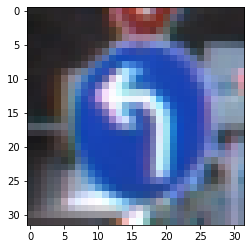

In [6]:
# Preview image
inx = 20123
plt.imshow(signimages['features'][inx])
print("The image shows a {} sign".format(signnames[signimages['labels'][inx]]))

In [7]:
train = pd.read_pickle(dataroot+"train.p")
test=pd.read_pickle(dataroot+"test.p")
valid=pd.read_pickle(dataroot+"valid.p")

In [8]:
train_classes = pd.DataFrame({'train': train['labels']})
test_classes = pd.DataFrame({'test': test['labels']})
valid_classes = pd.DataFrame({'valid': valid['labels'] })

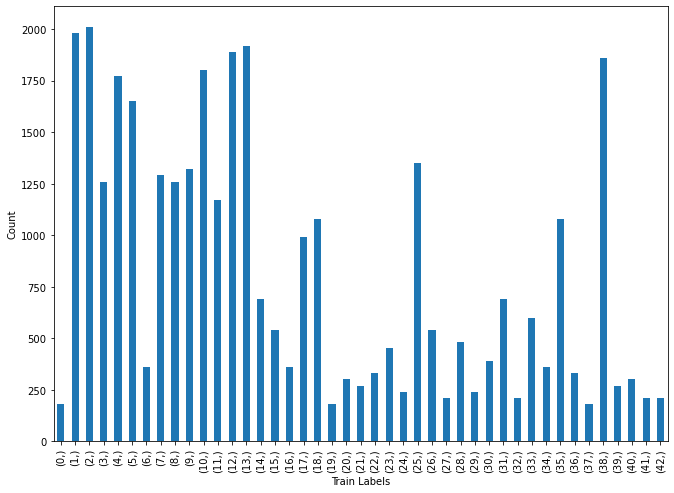

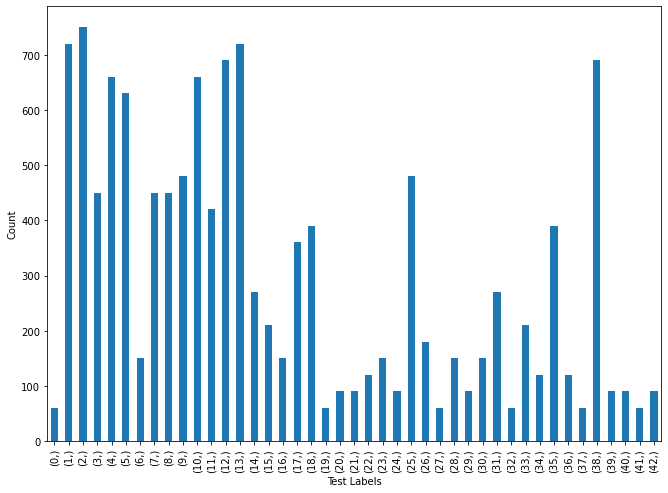

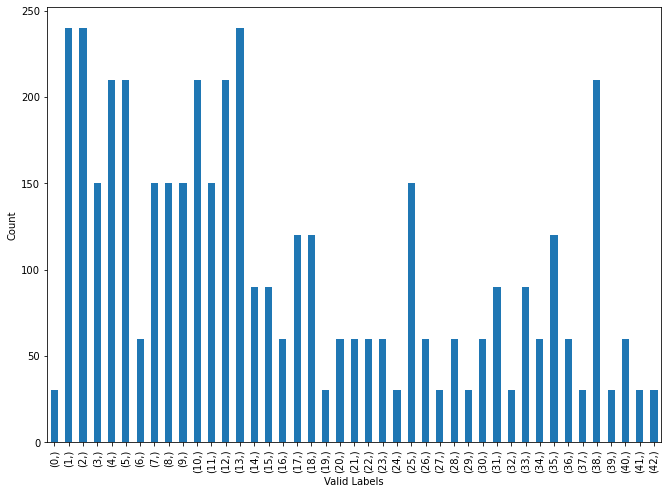

In [9]:
x = train_classes.value_counts().sort_index()
y=test_classes.value_counts().sort_index()
z=valid_classes.value_counts().sort_index()

plt.figure(figsize=(11,8))
x.plot(kind='bar')
plt.xlabel('Train Labels')
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(11,8))
y.plot(kind='bar')
plt.xlabel('Test Labels')
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(11,8))
z.plot(kind='bar')
plt.xlabel('Valid Labels')
plt.ylabel("Count")
plt.show()

In [10]:
len(train['features'])

34799

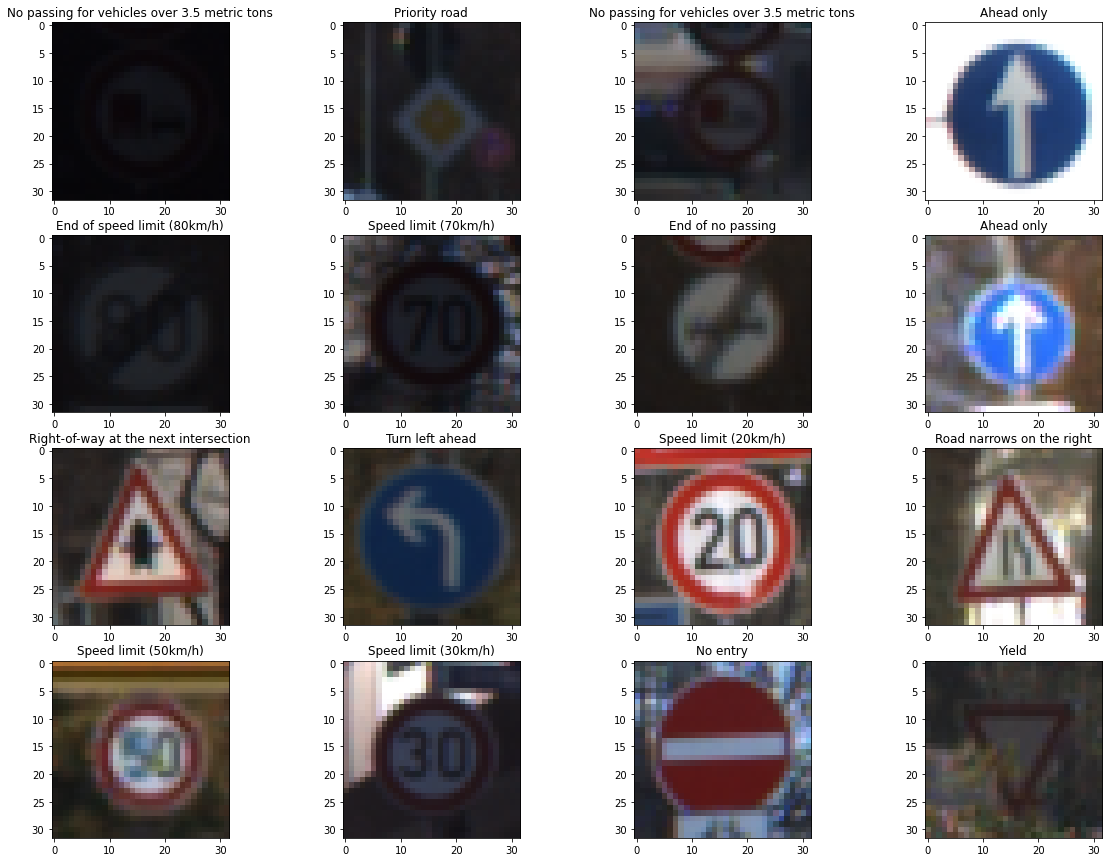

In [11]:
fig,axes = plt.subplots(4,4,figsize=(20,15))
axes = axes.ravel() # flatten

for i in range(0,16):
    idx = random.randint(0,len(train['features']))
    axes[i].imshow(train['features'][idx])
    axes[i].set_title(signnames[train['labels'][idx]], fontsize = 12)
plt.show()

In [12]:
#scale the pixel intensities down to the 0-1 range by dividing by 255.0

X_train, y_train = train["features"]/255.0, train["labels"]
X_test, y_test = test["features"]/255.0, test["labels"]
X_valid, y_valid = valid["features"]/255.0, valid["labels"]

In [13]:
X_train.shape

(34799, 32, 32, 3)

In [14]:
y_train.shape

(34799,)

In [15]:
#Build Neural Net
model = keras.models.Sequential([
    #input layer
    keras.layers.Conv2D(filters = 16, activation='relu', 
                        kernel_size= 3, padding = 'same', input_shape=(32, 32, 3)),
    #convolution layers
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), padding = 'same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding= 'same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3,3), padding = 'same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2,2)),

    #fully connected layer
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1024, activation = 'relu'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(43, activation='softmax')
    
])


2021-10-12 17:58:03.083190: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-12 17:58:03.083848: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        9280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0

In [17]:
optimizer = 'adam'
checkpoint_filepath = 'weights.{epoch:02d}-{val_loss:.2f}.hdf5'

checkpointer = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, 
                               verbose=1, 
                               save_best_only=True)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"],
             callbacks = [early_stop,checkpointer])

In [18]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Train on 34799 samples, validate on 4410 samples
Epoch 1/30
34799/34799 [==============================] - 791s 23ms/sample - loss: 0.2550 - accuracy: 0.9324 - val_loss: 0.1376 - val_accuracy: 0.9592
Epoch 2/30
34799/34799 [==============================] - 779s 22ms/sample - loss: 0.0330 - accuracy: 0.9896 - val_loss: 0.1918 - val_accuracy: 0.9535
Epoch 3/30
34799/34799 [==============================] - 777s 22ms/sample - loss: 0.0199 - accuracy: 0.9937 - val_loss: 0.1809 - val_accuracy: 0.9506
Epoch 4/30
34799/34799 [==============================] - 776s 22ms/sample - loss: 0.0263 - accuracy: 0.9918 - val_loss: 0.2350 - val_accuracy: 0.9444
Epoch 5/30
34799/34799 [==============================] - 792s 23ms/sample - loss: 0.0218 - accuracy: 0.9939 - val_loss: 0.1612 - val_accuracy: 0.9642
Epoch 6/30
34799/34799 [==============================] - 802s 23ms/sample - loss: 0.0203 - accuracy: 0.9942 - val_loss: 0.1857 - val_accuracy: 0.9562
Epoch 7/30
34799/34799 [=====================

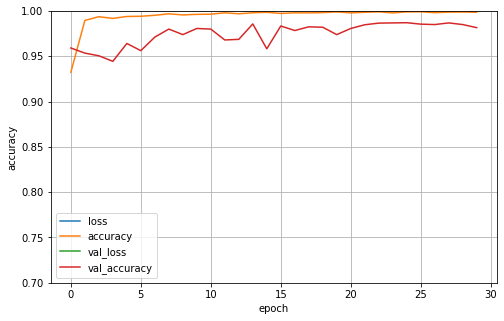

In [19]:
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0.7,1)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

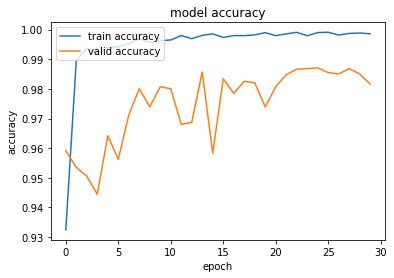

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'valid accuracy'], loc='upper left')
plt.show()

In [23]:
#model.load_weights('img_model.weights.best.hdf5')

y_pred = model.predict_classes(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f'Overall Test Accuracy: {test_acc*100:.3f}')

Overall Test Accuracy: 97.783


In [25]:
print(f'Overall Test Accuracy: {test_acc*100:.3f}')

Overall Test Accuracy: 97.783


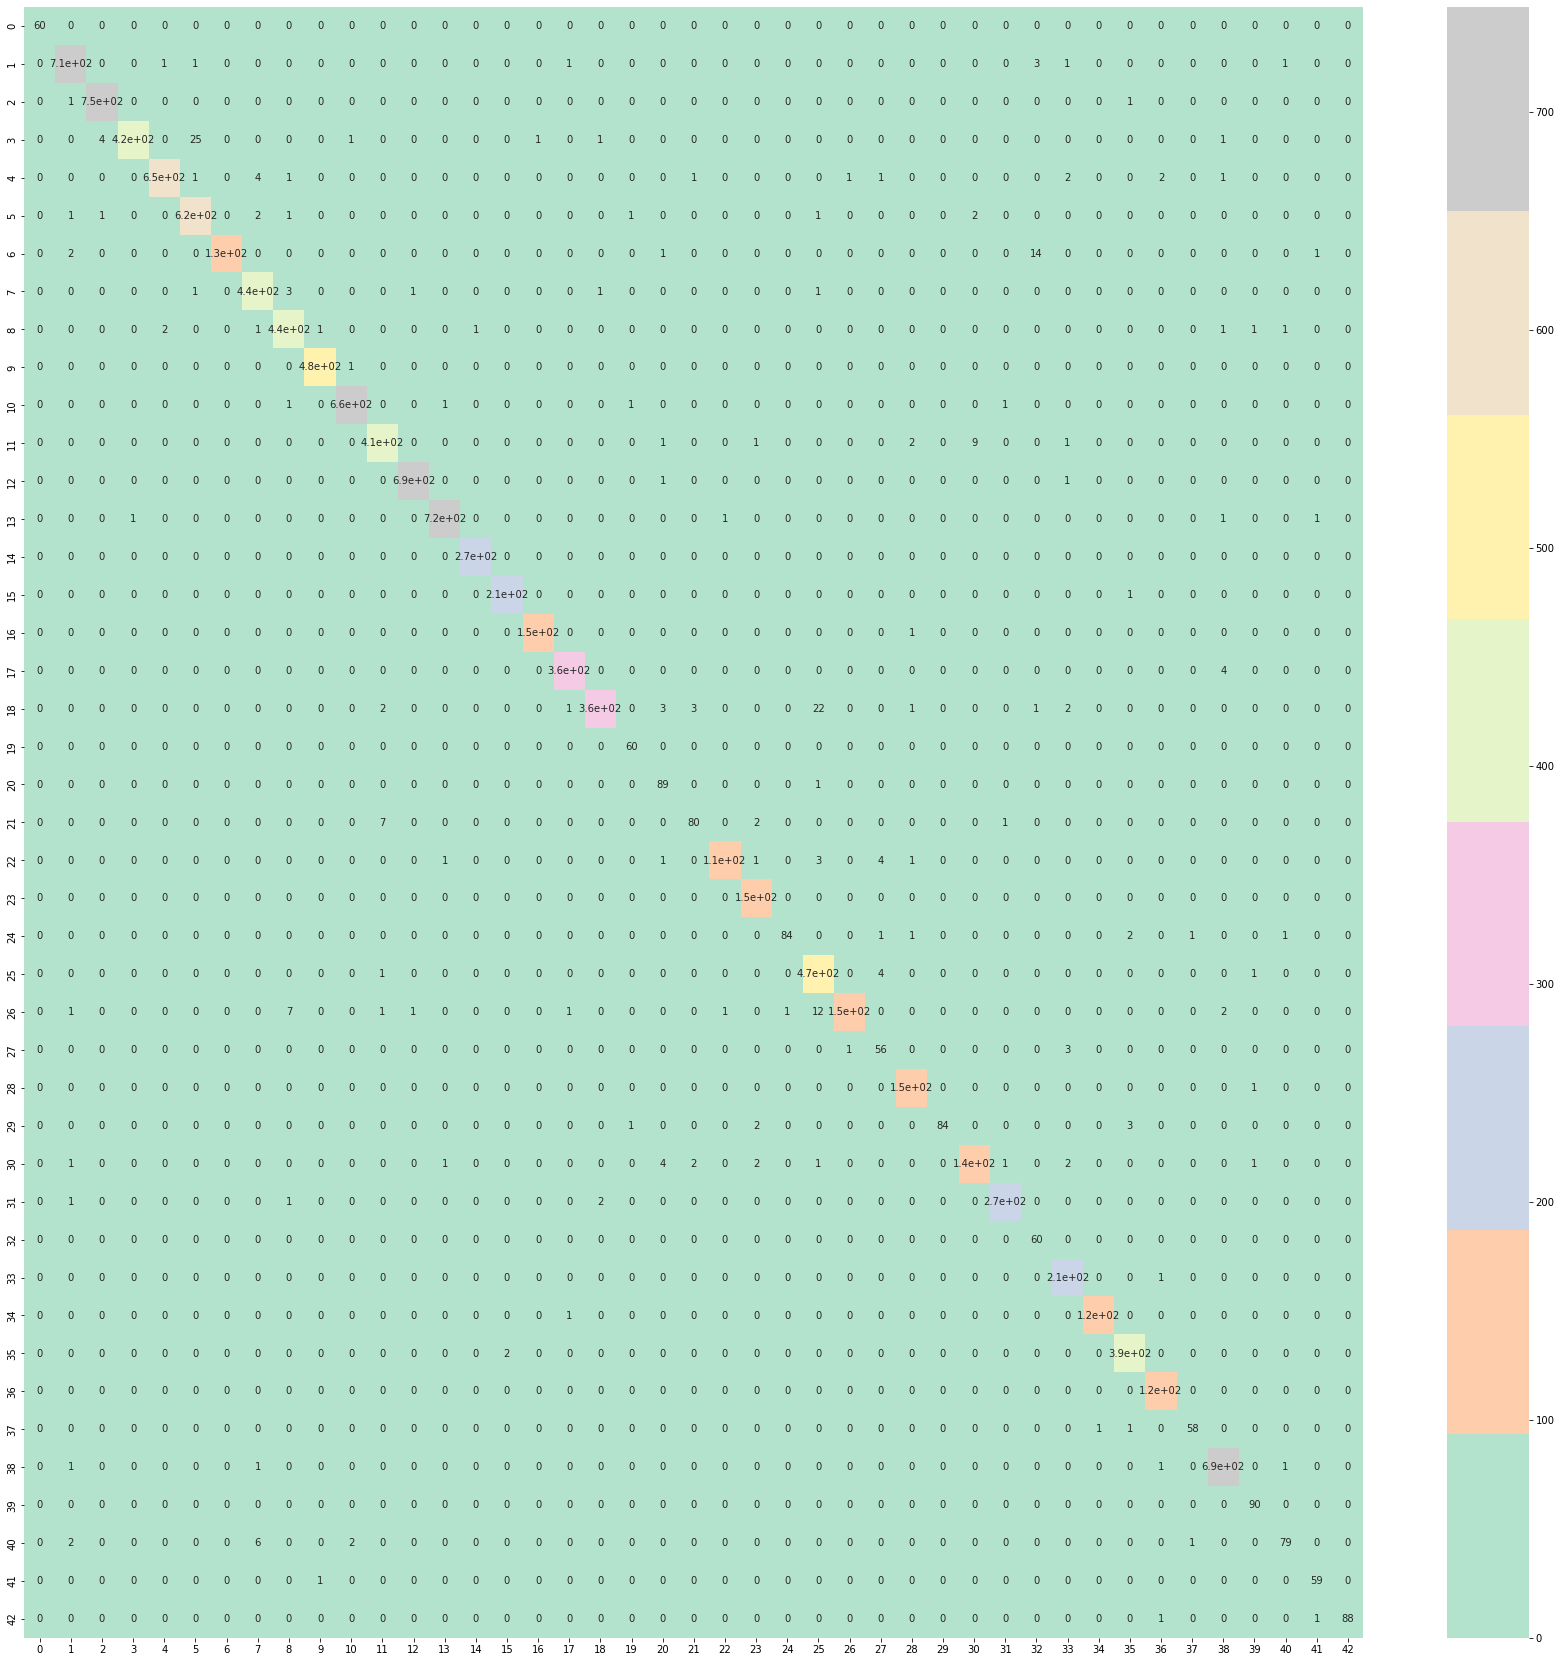

In [26]:
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(30,30))
sns.heatmap(cm,annot=True, cmap="Pastel2");

In [27]:


def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    
    print(f'Overall Test Accuracy: {test_acc*100:.3f}')
    return results
stats_df = display_results(y_test, y_pred, signnames.values())

Overall Test Accuracy: 97.783


In [28]:
from tabulate import tabulate

In [29]:
print(tabulate(stats_df, headers='keys', tablefmt='psql', 
               numalign="right", floatfmt=(None, ".4f", ".4f", ".4f")))

+----------------------------------------------------+-------------+----------+-----------+-----------+
|                                                    |   Precision |   Recall |   F-Score |   Support |
|----------------------------------------------------+-------------+----------+-----------+-----------|
| Speed limit (20km/h)                               |      1.0000 |   1.0000 |    1.0000 |        60 |
| Stop                                               |      0.9963 |   1.0000 |    0.9982 |       270 |
| Priority road                                      |      0.9971 |   0.9971 |    0.9971 |       690 |
| No passing                                         |      0.9958 |   0.9979 |    0.9969 |       480 |
| Speed limit (50km/h)                               |      0.9934 |   0.9973 |    0.9953 |       750 |
| Yield                                              |      0.9958 |   0.9944 |    0.9951 |       720 |
| No passing for vehicles over 3.5 metric tons       |      0.99

In [34]:
low_scores = ['Traffic signals', 'Roundabout mandatory', 'Beware of ice/snow', 
              'Double curve', 'Pedestrians', 'End of all speed and passing limits']
high_scores = ['Speed limit (20km/h)', 'Stop', 'Priority road', 
               'No passing', 'Speed limit (50km/h)', 'Yield']

In [35]:
keys_low = list(map(list(signnames.values()).index, low_scores))
keys_high = list(map(list(signnames.values()).index, high_scores))

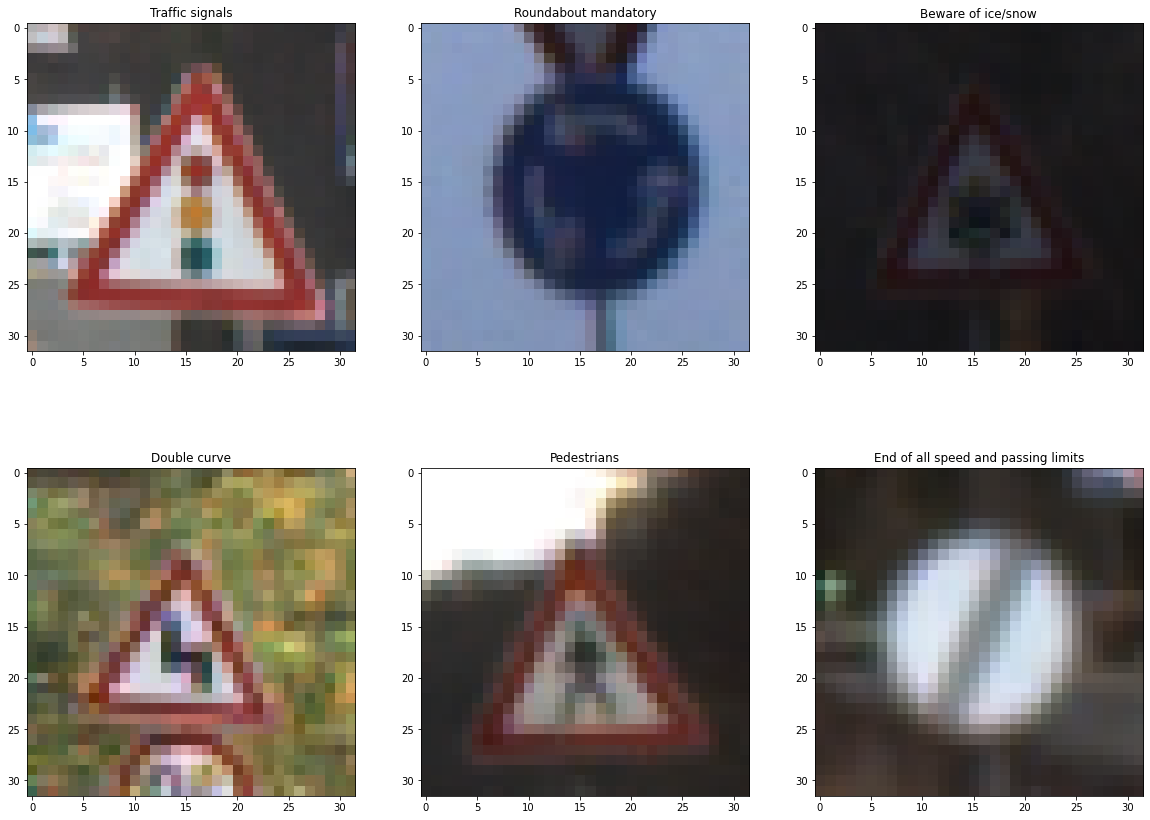

In [36]:
fig,axes = plt.subplots(2,3,figsize=(20,15))
axes = axes.ravel() # flatten

for i, key in enumerate(keys_low):
    idx = np.where(test['labels']==key)[0][0]
    axes[i].imshow(test['features'][idx])
    axes[i].set_title(signnames[test['labels'][idx]], fontsize = 12)
plt.show()

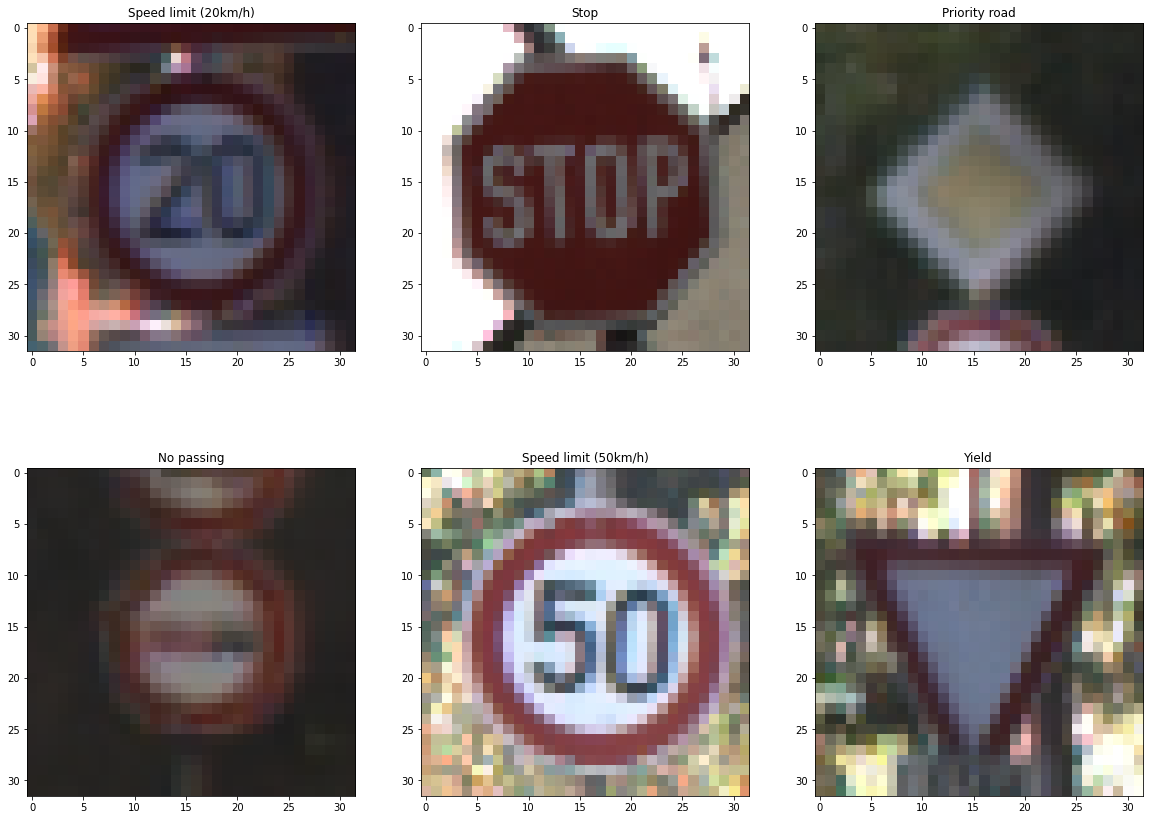

In [37]:
fig,axes = plt.subplots(2,3,figsize=(20,15))
axes = axes.ravel() # flatten

for i, key in enumerate(keys_high):
    idx = np.where(test['labels']==key)[0][0]
    axes[i].imshow(test['features'][idx])
    axes[i].set_title(signnames[test['labels'][idx]], fontsize = 12)
plt.show()